# Workflow
``chainladder`` facilitates practical reserving workflows.

In [18]:
import chainladder as cl
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

(workflow:pipeline)=
## Pipeline
The :class:`Pipeline` class implements utilities to build a composite
estimator, as a chain of transforms and estimators.  Said differently, a
`Pipeline` is a way to wrap multiple estimators into a single compact object.
The `Pipeline` is borrowed from scikit-learn.  As an example of compactness,
we can simulate a set of triangles using bootstrap sampling, apply volume-weigted
development, exponential tail curve fitting, and get the 95%-ile IBNR estimate.


In [19]:
pipe = cl.Pipeline(
    steps=[
    ('sample', cl.BootstrapODPSample(random_state=42)),
    ('dev', cl.Development(average='volume')),
    ('tail', cl.TailCurve('exponential')),
    ('model', cl.Chainladder())])

pipe.fit(cl.load_sample('genins'))

Pipeline(steps=[('sample', BootstrapODPSample(random_state=42)),
                ('dev', Development()), ('tail', TailCurve()),
                ('model', Chainladder())])

Each estimator contained within a pipelines ``steps`` can be accessed by name
using the ``named_steps`` attribute of the `Pipeline`.

In [20]:
pipe.named_steps.model.ibnr_.sum('origin').quantile(q=.95)

26063265.939845018

As mentioned in the `Development` section, a `Pipeline` coupled with `groupby` can really streamline you reserving analysis. Here we can develop IBNR for each company using LOB level development patterns. By delegating the `groupby` operation to the `Development` estimator in the `Pipeline`, we can fully specify the entire analysis as part of our hyperparameters.  This achieves a clear separation of assumption setting from data manipulation.

In [21]:
clrd = cl.load_sample('clrd')['CumPaidLoss']

pipe = cl.Pipeline(
    steps=[
    ('dev', cl.Development(groupby='LOB')),
    ('tail', cl.TailCurve('exponential')),
    ('model', cl.Chainladder())]).fit(clrd)

pipe.named_steps.model.ibnr_

,Triangle Summary
Valuation:,2261-12
Grain:,OYDY
Shape:,"(775, 1, 10, 1)"
Index:,"[GRNAME, LOB]"
Columns:,[CumPaidLoss]


(workflow:votingchainladder)=
## VotingChainladder

The :class:`VotingChainladder` ensemble method allows the actuary to vote between
different underlying ``ibnr_`` by way of a matrix of weights.

For example, the actuary may choose 
* the :class:`Chainladder` method for the first 4 origin periods, 
* the :class:`BornhuetterFerguson` method for the next 3 origin periods,
* and the :class:`CapeCod` method for the final 3.

In [22]:
raa = cl.load_sample('RAA')
cl_ult = cl.Chainladder().fit(raa).ultimate_ # Chainladder Ultimate
apriori = cl_ult*0+(cl_ult.sum()/10) # Mean Chainladder Ultimate

bcl = cl.Chainladder()
bf = cl.BornhuetterFerguson()
cc = cl.CapeCod()

estimators = [('bcl', bcl), ('bf', bf), ('cc', cc)]
weights = np.array([[1, 0, 0]] * 4 + [[0, 1, 0]] * 3 + [[0, 0, 1]] * 3)
vot = cl.VotingChainladder(estimators=estimators, weights=weights)
vot.fit(raa, sample_weight=apriori)
vot.ultimate_

,2261
1981,"18,834"
1982,"16,858"
1983,"24,083"
1984,"28,703"
1985,"28,204"
1986,"19,840"
1987,"18,840"
1988,"23,107"
1989,"20,005"
1990,"21,606"


Alternatively, the actuary may choose to combine all methods using weights. Omitting
the weights parameter results in the average of all predictions assuming a weight of 1.
Alternatively, a default weight can be enforced through the `default_weight` parameter.


In [23]:
raa = cl.load_sample('RAA')
cl_ult = cl.Chainladder().fit(raa).ultimate_ # Chainladder Ultimate
apriori = cl_ult * 0 + (float(cl_ult.sum()) / 10) # Mean Chainladder Ultimate

bcl = cl.Chainladder()
bf = cl.BornhuetterFerguson()
cc = cl.CapeCod()

estimators = [('bcl', bcl), ('bf', bf), ('cc', cc)]
vot = cl.VotingChainladder(estimators=estimators)
vot.fit(raa, sample_weight=apriori)
vot.ultimate_

,2261
1981,"18,834"
1982,"16,887"
1983,"24,042"
1984,"28,436"
1985,"28,467"
1986,"19,771"
1987,"18,548"
1988,"23,305"
1989,"18,530"
1990,"20,331"


The weights can take the form of an array (as above), a dict, or a callable:


In [24]:
callable_weight = lambda origin : np.where(origin.year < 1985, (1, 0, 0), np.where(origin.year > 1987, (0, 0, 1), (0, 1, 0)))

dict_weight = {
    '1992': (0, 1, 0),
    '1993': (0, 1, 0),
    '1994': (0, 1, 0),
    '1995': (0, 0, 1),
    '1996': (0, 0, 1),
    '1997': (0, 0, 1),
}  # Unmapped origins will get `default_weight`


(workflow:gridsearch)=
GridSearch
==========
The grid search provided by :class:`GridSearch` exhaustively generates
candidates from a grid of parameter values specified with the ``param_grid``
parameter.  Like `Pipeline`, `GridSearch` borrows from its scikit-learn counterpart
``GridSearchCV``.

Because reserving techniques are different from supervised machine learning,
`GridSearch` does not try to pick optimal hyperparameters for you. It is more of
a scenario-testing estimator.

```{tip}
The [tryangle](https://github.com/casact/tryangle) package takes the machine learning aspect a bit farther than `chainladder` and 
has built in scoring functions that make hyperparameter tuning in a reserving context possible.
```

`GridSearch` can be applied to all other estimators, including the `Pipeline`
estimator.  To use it, one must specify a ``param_grid`` as well as a ``scoring``
function which defines the estimator property(s) you wish to capture.  

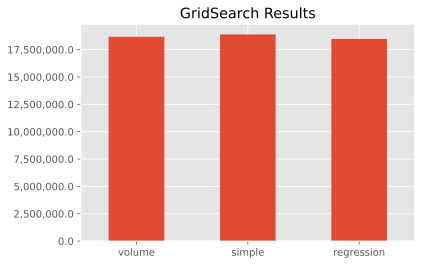

In [47]:
pipe = cl.Pipeline(
    steps=[('dev', cl.Development()),
           ('model', cl.Chainladder())])

grid = cl.GridSearch(
    estimator=pipe,
    param_grid={'dev__average' :['volume', 'simple', 'regression']},
    scoring=lambda x : x.named_steps.model.ibnr_.sum('origin'))

grid.fit(cl.load_sample('genins'))
ax = grid.results_.set_index('dev__average').rename(columns={'score': 'IBNR'}).plot(
    kind='bar', legend=False, xlabel='', rot=0, title='GridSearch Results')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda value, tick_number: "{:,}".format(float(value))));


A couple points on the example.

1. The syntax for GridSearch is a near replica of scikit-learn's `GridsearchCV`
2. The `param_grid` is a dictionary of hyperparamter names and possible options you may want to use.
3. Multiple different hyperparameters can be specified in a `param_grid`. Doing so will create a cartesian product of all possible assumptions.
4. When using a `Pipeline` in a `GridSearch` it is entirely possible that the `param_grid` hyperparameter names used in different steps of a the `Pipeline` can clash.  The notation to disambiguate the hyperparameters is to specify both the step and the hyperparameter name in this fashion: `step__hyperparameter`

```{note}
All of this can be done with loops, but GridSearch provides a nice shorthand for accomplishing the same as well as parallelism when your CPU has multiple cores.
```

Your `scoring` function can be any property derived off of the fitted etimator.
If capturing multiple properties is desired, multiple scoring functions can be created and
stored in a dictionary.

Here we capture multiple properties of the `TailBondy` estimator using the
`GridSearch` routine to test the sensitivity of the model to changing hyperparameters.


In [36]:
# Fit basic development to a triangle
tri = cl.load_sample('tail_sample')['paid']
dev = cl.Development(average='simple').fit_transform(tri)

# Return both the tail factor and the Bondy exponent in the scoring function
scoring = {
    'Tail Factor (tail_)': lambda x: x.tail_.values[0,0],
    'Bondy Exponent (b_)': lambda x : x.b_.values[0,0]}

# Vary the 'earliest_age' assumption in GridSearch
param_grid=dict(earliest_age=list(range(12, 120, 12)))
grid = cl.GridSearch(
    estimator=cl.TailBondy(), 
    param_grid=param_grid, 
    scoring=scoring)

grid.fit(dev).results_

,earliest_age,Tail Factor (tail_),Bondy Exponent (b_)
0,12,1.027763,0.624614
1,24,1.027983,0.625014
2,36,1.029856,0.629534
3,48,1.037931,0.651859
4,60,1.048890,0.683528
5,72,1.046617,0.674587
6,84,1.059931,0.714418
7,96,1.072279,0.746943
8,108,1.023925,0.500000


Using `GridSearch` for scenario testing is entirely optional.  You can write
your own looping mechanisms to achieve the same result.  For example:

<!-- TODO: what is supposed to be showing here? -->

```{eval-rst}
.. figure:: /auto_examples/images/sphx_glr_plot_capecod_001.png
   :target: ../auto_examples/plot_capecod.html
   :align: center
   :scale: 50%
```

It is also possible to treat estimators themselves as hyperparameters.  A `GridSearch` can search over `Chainladder` and `CapeCod` or any other estimator. To achieve this, you can take your `param_grid` dictionary and make it a list of dictionaries.

In [61]:
clrd = cl.load_sample('clrd')[['CumPaidLoss', 'EarnedPremDIR']].groupby('LOB').sum().loc['medmal']

grid = cl.GridSearch(
    estimator = cl.Pipeline(steps=[
        ('dev', None),
        ('model', None)]),
    param_grid = [
        {'dev': [cl.Development()],
         'dev__n_periods': [-1, 3, 7],
         'model': [cl.Chainladder()]},
        {'dev': [cl.Development()],
         'dev__n_periods': [-1, 3, 7],
         'model': [cl.CapeCod()],
         'model__decay': [0, .5, 1]}],
    scoring=lambda x : x.named_steps.model.ibnr_.sum('origin')
)

grid.fit(
    X=clrd['CumPaidLoss'], 
    sample_weight=clrd['EarnedPremDIR'].latest_diagonal)

grid.results_

,dev,dev__n_periods,model,score,model__decay
0,Development(n_periods=7),-1,Chainladder(),1.330331e+06,NaN
1,Development(n_periods=7),3,Chainladder(),1.254405e+06,NaN
2,Development(n_periods=7),7,Chainladder(),1.321097e+06,NaN
3,Development(n_periods=7),-1,CapeCod(),1.330331e+06,0.0
4,Development(n_periods=7),-1,CapeCod(),1.278456e+06,0.5
5,Development(n_periods=7),-1,CapeCod(),1.066857e+06,1.0
6,Development(n_periods=7),3,CapeCod(),1.254405e+06,0.0
7,Development(n_periods=7),3,CapeCod(),1.225866e+06,0.5
8,Development(n_periods=7),3,CapeCod(),1.040709e+06,1.0
9,Development(n_periods=7),7,CapeCod(),1.321097e+06,0.0


The workflow estimators are incredibly flexible for composing any compound reserving workflow into a single estimator.  These succintly capture all "assumptions" and model definitions in one place.